# Couches de convolutions 

## Motivation

Nous avons vu dans les cours précédents l'utilisation des réseaux de neurones entièrement connectés (ou Fully Connected) sur des images. Pour rappel, nous avions utilisé le dataset MNIST composé d'images en nuance de gris de taille $28 \times 28$ pour introduire la normalisation et montrer l'utilisation d'un réseau de neurones pour le traitement d'images.   
Cependant, l'entrée de notre réseau était de taille $28 \times 28 = 784$ ce qui est une taille d'entrée assez conséquente pour un réseau de neurones malgré la petite taille de l'image d'entrée.  Pour une image de taille $224 \times 224 \times 3$ (petite image pour les standards actuels), on aurai une taille d'entrée de $150528$ ce qui est inenvisable pour un traitement rapide.

## Solutions

### Redimensionnement 

Pour résoudre ce problème, on peut envisager de redimensionner l'image d'entrée mais, en faisant cela, la perte d'informations est trop importante et on ne reconnaît même plus l'objet sur l'image. 

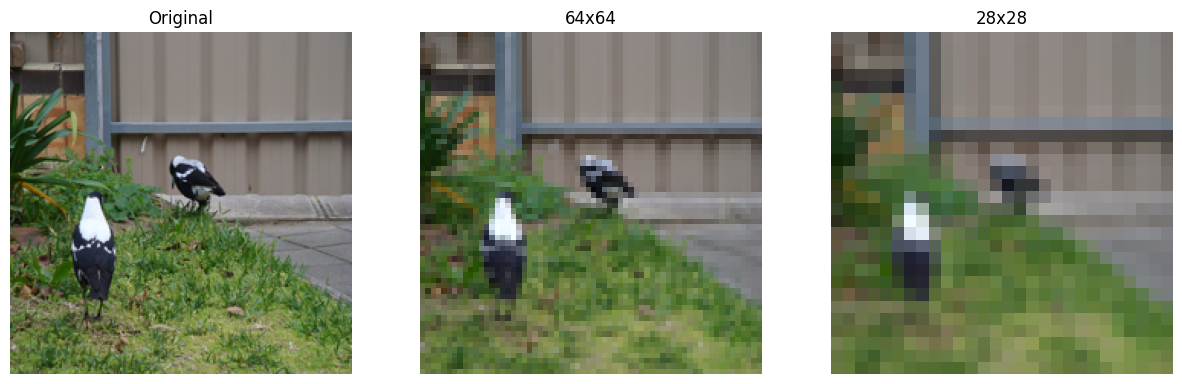

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

img=Image.open("images/SampleImageNet.JPEG").resize((224,224))
imgResized_64=img.resize((64,64))
imgResized_28=img.resize((28,28))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis('off')  
axes[1].imshow(imgResized_64)
axes[1].set_title("64x64")
axes[1].axis('off')  
axes[2].imshow(imgResized_28)
axes[2].set_title("28x28")
axes[2].axis('off')
plt.show()

Comment on peut le voir, le redimensionnement n'est pas la bonne solution surtout si l'on a besoin d'identifier des détails de l'image pour une classification ou détection efficace. 

### Première couche cachée très limitée 

Une entrée de taille $150528$ est d'autant plus problématique lorsque l'on a une première couche cachée qui contient également un nombre important de neurones. En effet, les poids correspondent à chaque connexion entre deux neurones de couches successives. Si on suppose que la première couche cachée a $1024$ neurones, on aurait $150528*1024 = 154 \text{ millions}$ de poids ce qui est colossal pour uniquement la liaison entre les deux premières couches.  
On pourra alors envisager d'avoir une première couche cachée quelques dizaines de neurones maximum pour limiter le nombre de poids. Cependant, avoir une réduction drastique de la dimension résulte en une perte énorme d'informations et ne permet donc pas d'avoir des résultats satisfaisants avec cette méthode.  

### Convolutions

**Intuition** : Une particularité des images est la présence de motifs récurrents. A partir de cette idée, on peut envisager un partage de poids entre les différents pixels de l'image.  
**Principe de base** : Cela nous conduit à l'utilisation des couches de convolutions qui utilisent filtres de convolutions parcourant chaque pixel de l'image. Les valeurs de ces filtres sont entraînables et correspondent aux poids de notre réseau de neurones.  
Voici une illustration du principe de convolution :  
<img src="images/conv.png" alt="Convolution" width="600"/>

**Pourquoi ça marche ?** : 
- L'utilisation des couches de convolutions permet de ne pas augmenter le nombre de poids en fonction de la taille de l'image, cela permet donc de traiter des images de résolutions importantes. 
- La couche de convolution permet une invariance à la translation ce qui est très intéressant pour une image (Une image de chien decalée de 4 pixels reste une image de chien).
- Même si le traitement de l'information est locale sur une couche de convolution, la succession de couches de convolutions permet d'avoir un traitement global de l'image (voir partie sur le champ réceptif).  

**Informations supplémentaires** : Sur la figure d'explication, l'image d'entrée est de taille $4 \times 4$. En pratique, une image couleur contient $3$ canaux. Pour traîter une image de taille $4 \times 4 \times 3$, on utiliserait des filtres de taille $n \times n \times 3$ avec $n$ la taille du filtrer ($3$ sur la figure d'explication). Il faut retenir que la profondeur du filtre de convolution dépend du nombre de canaux de l'entrée de la couche. 

## Couche de convolution en détail

Nous allons maintenant détailler les différents paramètres d'une couche de convolution en se basant sur les paramètres d'entrée de la fonction [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) de pytorch.  
Pour plus de clarté, la sortie d'une couche de convolutions est appelée $FeatureMap$. 

**in_channels** : Le nombre de canaux en entrée de la couche (permet de définir la profondeur des filtres de convolutions utilisés)   

**out_channels** : Le nombre de filtres de convolutions utilisés dans la couche (correspond également au nombre de canaux de la $FeatureMap$ de sortie).  

**kernel_size** : La taille d'une filtre de convolution, si  ce paramètre vaut $3$ alors le filtre de convolution est de taille $3 \times 3$. Tous les filtres de convolution d'une même couche ont forcément la même taille.  

**stride** : Le stride correspond au pas de l'application du filtre de convolution. Par exemple, un stride de $1$ signifie qu'il faut appliquer le filtre sur tous les pixels tandis qu'un stride de $2$ signifie qu'il faut l'appliquer sur un pixel sur deux. Un stride important a pour effet de réduire la dimension de l'image (Avec un stride de 2, la $FeatureMap$ de sortie sera 2 fois plus petit qu'avec un stride de 1).   

**padding** : Ce paramètre ajoute une bordure de taille padding autour de l'image pour permettre aux filtres d'être appliqués uniformément sur tous les pixels, y compris ceux des bords. Sans padding, les pixels en bordure n'auraient pas de voisins pour le filtrage t ne pourrait pas être appliqués, ce qui réduirait la taille de l'image lors de la convolution. Le padding remédie à cela en ajoutant des valeurs (comme des zéros ou des valeurs réfléchies) autour de l'image avant d'appliquer les filtres (Voir zero-padding sur la figure d'explication).  

**padding_mode** : Permet de séléctionner le mode de padding ("zeros" pour zero_padding par exemple).

**dilation** : Le paramètre dilation dans une couche de convolution définit l'espacement entre les éléments du filtre, permettant à ce dernier de couvrir une zone plus large sans augmenter la taille du filtre, ce qui capture davantage de contexte spatial dans l'image. La figure suivante illustre la dilation :  
<img src="images/dilation.png" alt="Dilation" width="400"/>  
Figure extraite de "Du, Jinglong & Wang, Lulu & Liu, Yulu & Zhou, Zexun & He, Zhongshi & Jia, Yuanyuan. (2020). Brain MRI Super-Resolution Using 3D Dilated Convolutional Encoder–Decoder Network. IEEE Access. PP. 1-1. 10.1109/ACCESS.2020.2968395. "

## Couche de pooling

Une autre couche fondamentale des réseaux de neurones convolutifs est la couche de pooling. C'est une couche qui ne contient aucun paramètre apprenable et qui se contente de redimensionner la feature map à l'aide d'une technique de regroupement de pixels adjacents. Dans le notebook suivant, nous verrons comment cette couche s'utilise dans un réseau de neurones convolutif.  
Les couches de pooling ont aussi pour effet de réduire la sensibilité aux décalages et aux distorsions de motifs pour une plus grande généralisation. 

Il existe 2 types principaux de pooling :   
**MaxPooling** :  Le $MaxPooling$ est la méthode de pooling qui consiste à prendre la valeur maximum d'un groupe de pixels adjacents et de la définir comme nouvelle valeur de l'image réduite.  
**AveragePooling** : L'$AveragePooling$ prend la valeur moyenne du groupe de pixels adjacent et la définit comme nouvelle valeur de l'image réduite.  
La figure suivante montre les différences entre le $MaxPooling$ et l'$AveragePooling$ :   
<img src="images/pooling.png" alt="pooling" width="500"/>  